# Usecase showcasing Regional Benchmarking service of Anomaly Identification

With the OpenEO-based Regional Benchmarking service you can check the crop growth on a field and compare it with a similar fields. It gives you an idea of whether your field is performing better or worse than other fields.

In this example, we have compared several fields with similar croptype available in our area of interest. The area of interest is derived as WFS from DLV service filtered by a croptype(here, croptype = 'Zomergerst'). Nevertheless, if users have their polygons/parcels, they can use them with a note that they should be of similar crop type.

In [1]:
# importing necessary packages
import openeo
import rasterio
from rasterio.plot import show

In [3]:
# Acquire more information about the service
service = "Anomaly_Detection"
namespace = "vito"

eoconn = openeo.connect('https://openeo.vito.be').authenticate_oidc()
eoconn.describe_process(service, namespace=namespace)

Authenticated using refresh token.


{'id': 'Anomaly_Detection',
 'parameters': [{'description': 'Left-closed temporal interval, i.e. an array with exactly two elements:\n\n1. The first element is the start of the temporal interval. The specified instance in time is **included** in the interval.\n2. The second element is the end of the temporal interval. The specified instance in time is **excluded** from the interval.\n\nThe specified temporal strings follow [RFC 3339](https://www.rfc-editor.org/rfc/rfc3339.html). Also supports open intervals by setting one of the boundaries to `null`, but never both.',
   'name': 'date',
   'schema': {'examples': [['2015-01-01T00:00:00Z', '2016-01-01T00:00:00Z'],
     ['2015-01-01', '2016-01-01']],
    'items': {'anyOf': [{'format': 'date-time',
       'subtype': 'date-time',
       'type': 'string'},
      {'format': 'date', 'subtype': 'date', 'type': 'string'},
      {'maxLength': 4,
       'minLength': 4,
       'pattern': '^\\d{4}$',
       'subtype': 'year',
       'type': 'string'},
      {'type': 'null'}]},
    'maxItems': 2,
    'minItems': 2,
    'subtype': 'temporal-interval',
    'type': 'array'}},
  {'description': 'Loaded featurecollection object of the field geometries',
   'name': 'polygon',
   'schema': {'subtype': 'geojson', 'type': 'object'}},
  {'default': 'FAPAR',
   'description': 'BIOPAR type [FAPAR,FCOVER] used to calculate the CropSAR curve on. As default the FAPAR is used',
   'name': 'biopar_type',
   'optional': True,
   'schema': {'type': 'string'}}]}

As mentioned earlier, though, in this example, we used parcels from a WFS; these parameters are specific to them. User can use their polygons/parcels based on their requirements. 

In [2]:
# Specific parameters
croptype = 'Zomergerst'

# Bounding Box
west = 5.17
east = 5.3
south = 51.1
north = 52.246

In [ ]:
# reading the json file (user can use this function if they have their features stored as json file)

import json
def read_json_str(json_txt: str) -> dict:
    field = json.loads(json_txt)
    return field

## Parse the data

Here, we tried in parsing WFS provided by https://lv.vlaanderen.be/en as parcels with their crop types. 

In [3]:
# requesting data over a region for a specific crop type

import urllib
import requests

url = f"https://geo.api.vlaanderen.be/Landbgebrperc/wfs?service=WFS&request=getfeature&cql_filter=LBLHFDTLT='{croptype}'&outputformat=json&typename=Lbgebrperc&SRSName=urn:x-ogc:def:crs:EPSG:4326"
req = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})

wfs_request_url = requests.Request('GET', url,headers={'User-Agent': 'Mozilla/5.0'}).prepare().url
data = req.json()

Before proceeding forward, we want to ensure that the filtered data likes in the area of interest. Thus the following cell includes the method to display the parsed data as a dataframe and map.

In [9]:
import shapely
import geopandas as gpd
from shapely.geometry import box


dataframe = gpd.GeoDataFrame.from_features(data["features"],crs='EPSG:4326')

# filter data within the bounding box
bbox = box(west,south,east,north)
dataframe = dataframe[dataframe.within(bbox)]

dataframe = dataframe.head()
# converting dataframe to geojson string
geojson_str = dataframe.to_json()

dataframe

,geometry,UIDN,OIDN,ALVID,HFDTLT,LBLHFDTLT,GEWASGROEP,PM,LBLPM
19,"POLYGON ((5.17759388 51.13236902, 5.17754339 5...",4092306,1228344,1211525956,322,Zomergerst,"Granen, zaden en peulvruchten",,
47,"POLYGON ((5.24743582 51.10311003, 5.24843201 5...",1882791,1021017,1319447853,322,Zomergerst,"Granen, zaden en peulvruchten",,
57,"POLYGON ((5.17872085 51.17170835, 5.17848342 5...",4340847,1667648,2074973981,322,Zomergerst,"Granen, zaden en peulvruchten",,
82,"POLYGON ((5.21847254 51.27816026, 5.21847592 5...",4355462,1639446,2070875228,322,Zomergerst,"Granen, zaden en peulvruchten",,
129,"POLYGON ((5.2909333 51.20048401, 5.29085554 51...",4367507,1523096,1860308032,322,Zomergerst,"Granen, zaden en peulvruchten",,


In [7]:
# plot the polygons
import folium
map = folium.Map( tiles="open street map", zoom_start=12,location=[51.243,5.18])
points = folium.features.GeoJson(dataframe.to_crs('EPSG:4326').to_json())
map.add_child(points)
map.fit_bounds(map.get_bounds(), padding=(30, 30))
map

## Apply Anomaly Detection service


In [9]:
#parameters mandatory for this openeo-based service
aoi=read_json_str(geojson_str)
date = ["2020-03-06", "2020-06-30"]

#accessing the openeo service
anomaly = eoconn.datacube_from_process(service, namespace=namespace, date=date
                                       , polygon=aoi)

/home/pratixa/.local/lib/python3.6/site-packages/openeo/metadata.py:252: UserWarning: No cube:dimensions metadata
  complain("No cube:dimensions metadata")


In [11]:
# synchronous download or batch process
anomaly.download('RegionalBenchmarking_AD.json')

# # batch processing
# batch_job = anomaly.create_job(out_format = "json", title="Croptype")
# batch_job.start_and_wait()
# results = batch_job.get_results()
# results.download_files()

The service calculates the CropSAR fAPAR curve for each field and the regional average fAPAR curve calculated from comparable fields in the region during a given time period.

## Visualize and compare the final result

In [12]:
import matplotlib.pyplot as plt
import json

data_json = json.load(open('RegionalBenchmarking_AD.json', 'r'))

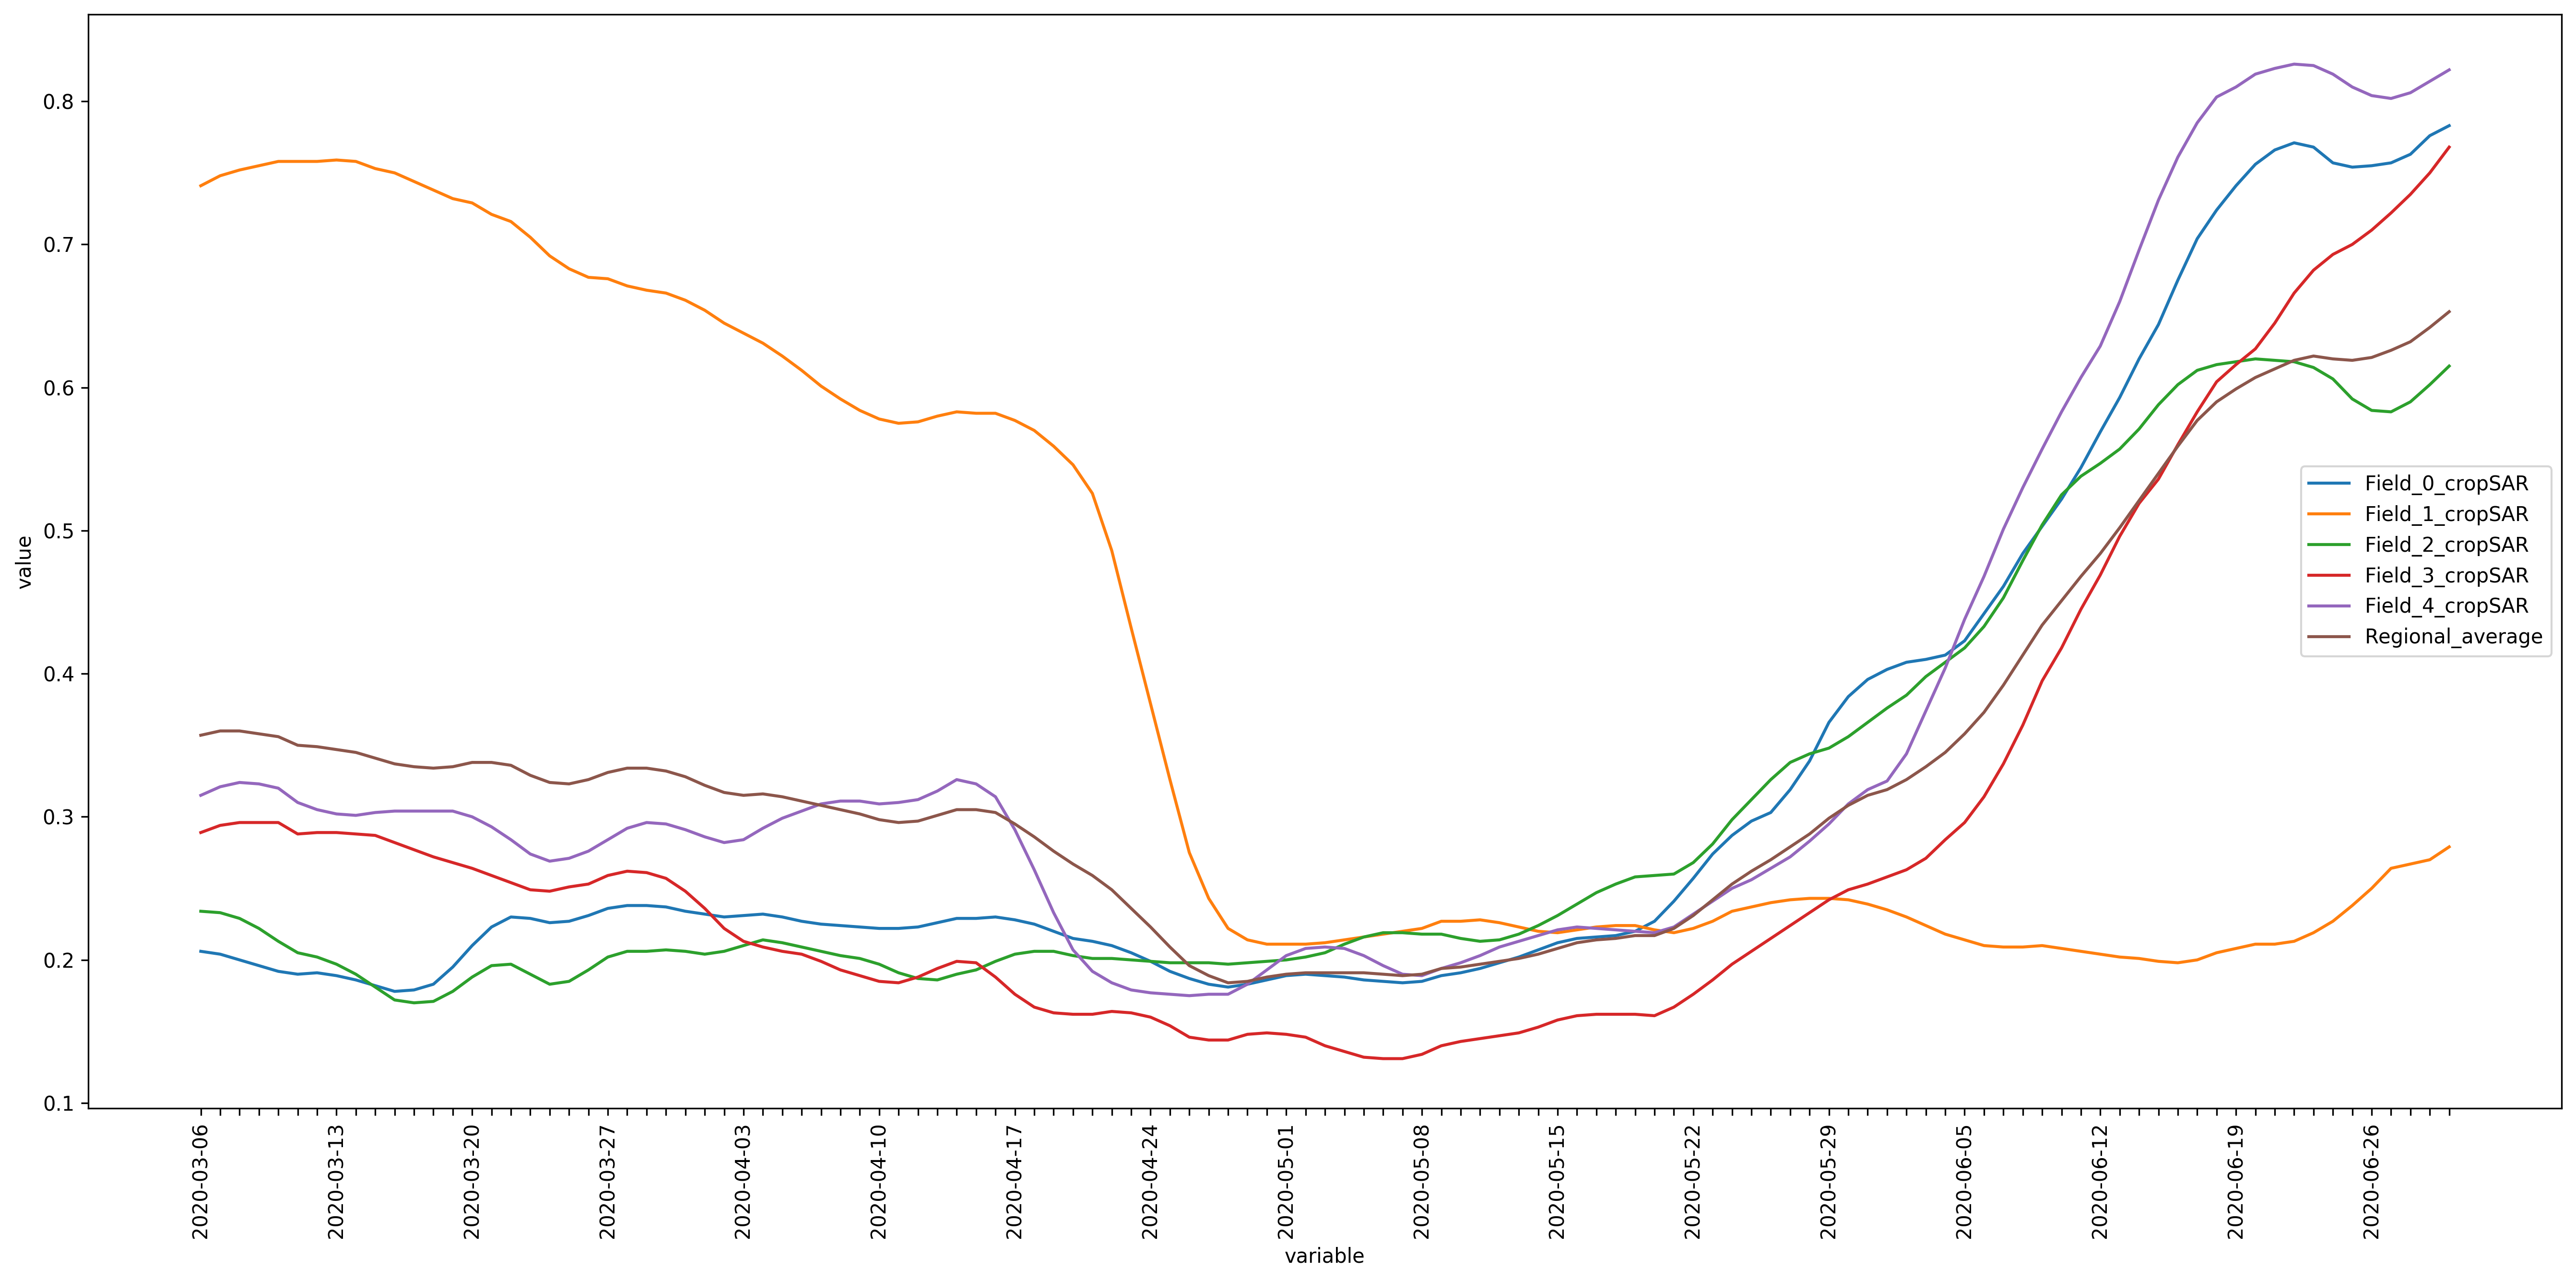

In [13]:
from matplotlib.pyplot import figure
import matplotlib.dates as mdates

figure(figsize=(18,9), dpi=300)
for i in data_json:
    x_Axis = [key for key, value in data_json[i].items()]
    y_Axis = [value for key, value in data_json[i].items()]
    plt.plot(x_Axis,y_Axis, label = i)

ax = plt.gca()
n = 7  # Keeps every 7th label
[l.set_visible(False) for (i,l) in enumerate(ax.get_xticklabels()) if i % n != 0]
plt.xlabel('variable')
plt.xticks(rotation=90)
plt.ylabel('value')
plt.tight_layout()
plt.legend()
plt.show()

Through the visualized curved you can study the croptype behaviour of the field in comparision with the Regional average.